In [16]:
import sys
from os.path import join,expanduser
user_home_dir = expanduser('~')

#point to the correct src path if this doesnt work
sys.path.insert(0,join(user_home_dir,'efs_ecco/ameza/ESS25-Team_SHERLOCCS/src'))

from src import * 

datadir = lambda x: "/efs_ecco/ameza/ESS25-Team_SHERLOCCS/notebooks/heat_budget/data/" + x

In [4]:
#  connect to existing LocalCluster
# the port number will be different!
client = Client("tcp://127.0.0.1:41551")
# client = Client()
client.ncores
client.restart()
client

<Client: 'tcp://127.0.0.1:41551' processes=0 threads=0, memory=0 B>

In [7]:
## Set top-level file directory for the ECCO NetCDF files
## =================================================================

## currently set to ~/Downloads/ECCO_V4r4_PODAAC, 
## the default if ecco_podaac_download was used to download dataset granules
ECCO_dir = join('/efs_ecco','ameza')

# for access_mode = 's3_open_fsspec', need to specify the root directory 
# containing the jsons
jsons_root_dir = join('/efs_ecco','mzz-jsons')

access_mode = 's3_open_fsspec'

## access datasets needed for this tutorial

ShortNames_list = ["ECCO_L4_GEOMETRY_LLC0090GRID_V4R4",\
                   "ECCO_L4_OCEAN_3D_TEMPERATURE_FLUX_LLC0090GRID_MONTHLY_V4R4",\
                   "ECCO_L4_HEAT_FLUX_LLC0090GRID_MONTHLY_V4R4",\
                   "ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4", \
                   "ECCO_L4_SSH_LLC0090GRID_SNAPSHOT_V4R4",\
                   "ECCO_L4_TEMP_SALINITY_LLC0090GRID_SNAPSHOT_V4R4"]
StartDate = '1991-01'
EndDate = '2018-12'
ds_dict = ea.ecco_podaac_to_xrdataset(ShortNames_list,\
                                            StartDate=StartDate,EndDate=EndDate,\
                                            mode=access_mode,\
                                            download_root_dir=ECCO_dir,\
                                            max_avail_frac=0.5,\
                                            jsons_root_dir=jsons_root_dir)

In [8]:
ds_GEOM = ds_dict[ShortNames_list[0]]

ds_3DTS = ds_dict['ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4']

ds_3DTFLUX = ds_dict['ECCO_L4_OCEAN_3D_TEMPERATURE_FLUX_LLC0090GRID_MONTHLY_V4R4']

ds_HFLUX = ds_dict['ECCO_L4_HEAT_FLUX_LLC0090GRID_MONTHLY_V4R4']

ds_SSH_snap = ds_dict['ECCO_L4_SSH_LLC0090GRID_SNAPSHOT_V4R4']
ds_TS_snap = ds_dict['ECCO_L4_TEMP_SALINITY_LLC0090GRID_SNAPSHOT_V4R4']

In [9]:
ds_snap = xr.merge([ds_SSH_snap, ds_TS_snap])
#make sure that the snapshots will line up with the monthly averages
constrain_fields_2_snap = lambda ds, ds_snap: ds.sel(time = slice(ds_snap.time.min(), ds_snap.time.max()))

ds_3D = xr.merge([ds_3DTS, ds_3DTFLUX])
ds_3D = constrain_fields_2_snap(ds_3D, ds_snap)
ds_2D = ds_HFLUX
ds_2D = constrain_fields_2_snap(ds_2D, ds_snap)

In [10]:
heat_budget = generate_heat_budget_terms(ds_2D, ds_3D, ds_snap, ds_GEOM)

load_binary_array: loading file /efs_ecco/ECCO/V4/r4/input/input_forcing/other/geothermalFlux.bin
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4


In [13]:
ccc_mask = xr.open_dataset("/efs_ecco/ameza/ESS25-Team_SHERLOCCS/masks/CCC_mask_Anthony.nc")
surf_heat_budget  = volume_average(heat_budget, ds_GEOM, ccc_mask["CCC_surf_mask"])
# surf_heat_budget = surf_heat_budget.chunk({'time':1}).isel(time = slice(0, 20))
surf_heat_budget = surf_heat_budget.chunk({'time':1})

surf_heat_budget.attrs.update({
    "Description":"Heat Budget for the mixed layer (0 - 50 meters) region of the California Coastal Current described in Zaba et. al 2020",
})

for v in surf_heat_budget.data_vars:
    surf_heat_budget[v].attrs['units'] = 'deg C per second'
    
output_fname = datadir("mixed_layer_heat_budget.nc")
surf_heat_budget = surf_heat_budget.compute()

surf_heat_budget.to_netcdf(output_fname)
print(f"Wrote diagnostics to {output_fname!r}")


/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 105.21 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Wrote diagnostics to 'data/mixed_layer_heat_budget.nc'


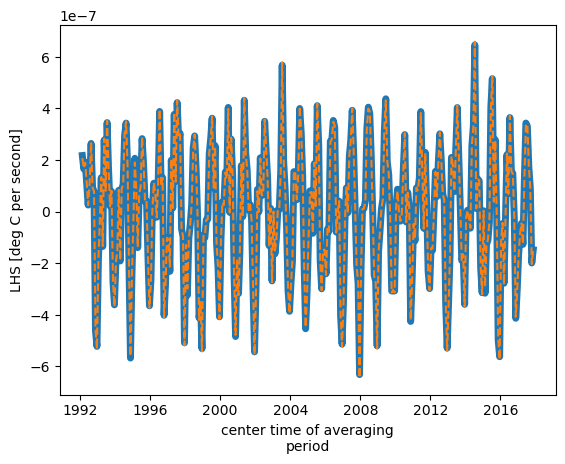

In [14]:
surf_heat_budget["RHS"].plot(lw = 5)
surf_heat_budget["LHS"].plot(linestyle = "--")

In [19]:
ccc_mask = xr.open_dataset("CCC_mask.nc")
surf_heat_budget  = volume_average(heat_budget, ds_GEOM, ccc_mask["CCC_sub_surf_mask"])
# surf_heat_budget = surf_heat_budget.chunk({'time':1}).isel(time = slice(0, 20))
surf_heat_budget = surf_heat_budget.chunk({'time':1})

surf_heat_budget.attrs.update({
    "Description":      "Heat Budget for the subsurface layer (100 - 210 meters) region of the California Coastal Current described in Zaba et. al 2020",
})

for v in surf_heat_budget.data_vars:
    surf_heat_budget[v].attrs['units'] = 'deg C per second'

    

output_fname = datadir("subsurface_layer_heat_budget.nc")
surf_heat_budget = surf_heat_budget.compute()

surf_heat_budget.to_netcdf(output_fname)
print(f"Wrote diagnostics to {output_fname!r}")


/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 105.21 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Wrote diagnostics to 'data/subsurface_layer_heat_budget.nc'


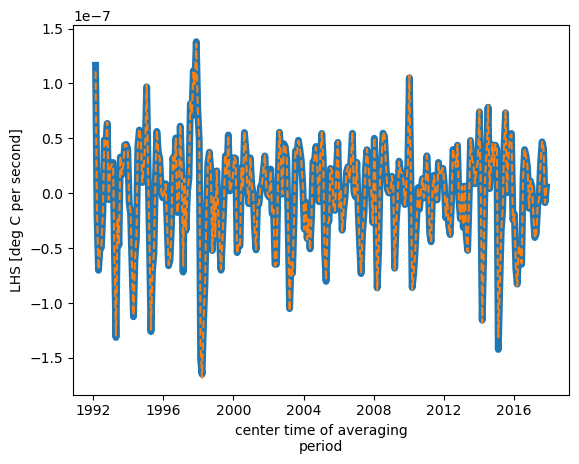

In [20]:
surf_heat_budget["RHS"].plot(lw = 5)
surf_heat_budget["LHS"].plot(linestyle = "--")